In [1]:
import numpy as np

## Download the dataset

In [81]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

## Smoothing

In [83]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

## Visualization of image data

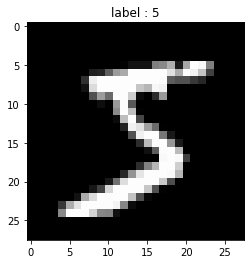

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

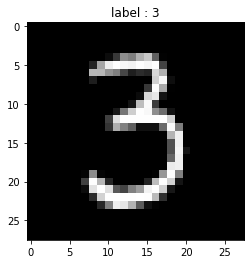

In [85]:
index = 50
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # Convert to float type
image -= 105.35 # Intentionally try to create a negative decimal value
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()
# print(image) # Check the value

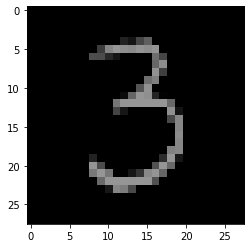

In [86]:
plt.imshow(image, 'gray', vmin = 0, vmax = 255)

## Preprocessing

Preprocess X

In [87]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


Split train - val data

In [88]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


One-hot encoding Y

In [89]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis])
print(y_train.shape)
print(y_train_one_hot.shape) 
print(y_train_one_hot.dtype)

(48000,)
(48000, 10)
float64


##**Problem 1 2 3 4 5 is in the implementation of Stratch Neural Network**

##Stratch Neural Network

In [92]:
class GetMiniBatch:
    """
Iterator to get a mini-batch
    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random number seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self
        
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [138]:
def sigmoid_function(X):
    return 1 / ( 1 + np.exp(-X) )

def hyperbolic_tangent_function(X):
    return np.tanh(X)

def sigmoid_derivative_function(X):
    return (1 - sigmoid_function(X)) * sigmoid_function(X)

def hyperbolic_tangent_derivative_function(X):
    return 1 - np.power(np.tanh(X),2)

def softmax_function(X):
    e = np.exp(X)
    return e / np.sum(e,
                      axis=1).reshape(-1,1)

class ScratchSimpleNeuralNetrowkClassifier():
    """
    Simple three-layer neural network classifier
    Parameters
    ----------
    Attributes
    ----------
    """

    def _activation_function(self, X):
        return self.__ACTIVATION_FUNCTION_DICT[self._activation](X)

    def _derivative_function(self, X):
        return self.__DERIVATIVE_FUNCTION_DICT[self._activation](X)
        
    __ACTIVATION_FUNCTION_DICT = {
        'sigmoid' :  sigmoid_function,
        'tanh'    :  hyperbolic_tangent_function
    }

    __DERIVATIVE_FUNCTION_DICT = {
        'sigmoid' :  sigmoid_derivative_function,
        'tanh'    :  hyperbolic_tangent_derivative_function
    }

    def __init__(self, hidden_layer_sizes=(400,200), activation='sigmoid', epoch=20, batch_size=20, learning_rate=0.01, sigma=0.01, verbose = True):
        self.verbose = verbose
        self._hidden_layer_sizes = hidden_layer_sizes
        self._activation = activation
        self.epoch = epoch
        self.batch_size = batch_size
        self.lr = learning_rate
        self._sigma = sigma

    def _init_coefs_intercepts(self, n_features, n_output):
        # Init coefs (weights), intercepts(biases)
        self.coefs_ = []
        self.intercepts_ = []

        # First layer of weight and bias
        self.coefs_.append(self._init_weight(n_features,self._hidden_layer_sizes[0]))
        self.intercepts_.append(self._init_bias(self._hidden_layer_sizes[0]))
        
        # Middle layers
        for i in range(len(self._hidden_layer_sizes)-1):
          self.coefs_.append(self._init_weight(self._hidden_layer_sizes[i], self._hidden_layer_sizes[i+1]))
          self.intercepts_.append(self._init_bias(self._hidden_layer_sizes[i+1]))

        # Last layer of weight and bias
        self.coefs_.append(self._init_weight(self._hidden_layer_sizes[-1],n_output))
        self.intercepts_.append(self._init_bias(n_output))

    def _init_weight(self, num_row, num_col):
        W = self._sigma * np.random.randn(num_row, num_col)
        return W

    def _init_bias(self, size):
        bias = self._sigma * np.random.randn(size)
        return bias
    
    def _feed_forward(self, X):
        self._layers = []
        A = np.dot(X, self.coefs_[0]) + self.intercepts_[0]
        Z = self._activation_function(A)
        self._layers.append(Z)
        for i in range(1, len(self.coefs_)):
          A = np.dot(Z, self.coefs_[i]) + self.intercepts_[i]
          Z = softmax_function(A) if i == len(self.coefs_)-1 else self._activation_function(A)
          self._layers.append(Z)
        return Z

    def _backpropagation(self, X, y):
        for i in range(len(self.coefs_)-1, -1, -1):
            # print(self._layers[i].shape)
            # print(y.shape)
            grad_a       = (self._layers[i]-y)/self.batch_size if i == len(self._layers)-1 else grad_z * self._derivative_function(self._layers[i])
            # print(f'grad_a shape: {grad_a.shape}')
            grad_bias    = np.sum(grad_a, axis=0)
            # print(f'grad_bias shape: {grad_bias.shape}')
            # print(np.dot(self._layers[i-1].T, grad_a))
            grad_weight  = np.dot(X.T, grad_a) if i == 0 else np.dot(self._layers[i-1].T, grad_a)
            # print(f'grad_weight shape: {grad_weight.shape}')
            grad_z       = np.dot(grad_a, self.coefs_[i].T)
            # print(f'grad_z shape: {grad_z.shape}')
            
            # Update weigts, biases
            # print(self.coefs_[i][0])
            # print(self.lr*grad_weight[0])
            self.coefs_[i]      -= self.lr*grad_weight
            # print(self.coefs_[i][0])
            # print()
            self.intercepts_[i] -= self.lr*grad_bias

    def _loss_function(self, y_true, prob_pred, tol=1e-07):
        return -np.mean(y_true*np.log(prob_pred + tol))

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : The following forms of ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        n_features  = X.shape[1] # number of features
        n_output     = y.shape[1] # number of output classes (number of nodes in the 3rd layer)
        
        #
        self.train_loss = []
        self.val_loss = []

        # init weights and biases
        self._init_coefs_intercepts(n_features, n_output)
        
        for i in range(self.epoch):
          get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
          for index, (X_batch, y_batch) in enumerate(get_mini_batch):
              # Feed forward
              self._feed_forward(X_batch)
              # Back prop
              self._backpropagation(X_batch, y_batch)

              # print(self.coefs_[0][0][0])

          self.train_loss.append(self._loss_function(y, self.predict_proba(X)))
          if X_val is not None and y_val is not None:
              self.val_loss.append(self._loss_function(y_val, self.predict_proba(X_val)))

          if self.verbose:
            print(f'epoch: {i}, loss: {self.train_loss[-1]}')

        return self

    def predict_proba(self, X):
        """
        Estimate using a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result
        """
        return self._feed_forward(X)

    def predict(self, X):
        """
        Estimate using a neural network classifier.
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample
        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result
        """
        y_proba = self.predict_proba(X)
        return np.argmax(y_proba, axis=1)

##**Problem 6**
##Learning and estimation

In [145]:
from sklearn.metrics import accuracy_score
y_val = enc.inverse_transform(y_val_one_hot)
y_val = y_val.ravel()

####**Train with the hyperbolic tangent function as the activation function**

In [146]:
model_tanh = ScratchSimpleNeuralNetrowkClassifier(activation='tanh', verbose=True)
model_tanh.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

epoch: 0, loss: 0.06692636703183524
epoch: 1, loss: 0.04077880554667709
epoch: 2, loss: 0.03460571326346844
epoch: 3, loss: 0.031572719451667855
epoch: 4, loss: 0.02932048063630939
epoch: 5, loss: 0.02748796920225955
epoch: 6, loss: 0.025931699357339133
epoch: 7, loss: 0.02458600641013818
epoch: 8, loss: 0.023373338335320924
epoch: 9, loss: 0.022225295397382317
epoch: 10, loss: 0.021110714875623132
epoch: 11, loss: 0.020025600398574445
epoch: 12, loss: 0.018978919801617245
epoch: 13, loss: 0.017980782179894083
epoch: 14, loss: 0.01703733044757967
epoch: 15, loss: 0.016150832137333086
epoch: 16, loss: 0.015320909871672613
epoch: 17, loss: 0.01454544845645491
epoch: 18, loss: 0.01382138450286117
epoch: 19, loss: 0.013145400016161176


In [142]:
y_pred_tanh = model_tanh.predict(X_val)
accuracy_score(y_pred_tanh, y_val)

0.95175

####**Train with the sigmoid function as the activation function**

In [147]:
model_sigmoid = ScratchSimpleNeuralNetrowkClassifier(activation='sigmoid', verbose=True)
model_sigmoid.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

epoch: 0, loss: 0.23102131414478314
epoch: 1, loss: 0.23094543516218763
epoch: 2, loss: 0.2308549592135755
epoch: 3, loss: 0.2307303025291711
epoch: 4, loss: 0.23051443746295391
epoch: 5, loss: 0.22997220749145136
epoch: 6, loss: 0.22737421334118862
epoch: 7, loss: 0.20203816866459662
epoch: 8, loss: 0.1641331718753498
epoch: 9, loss: 0.1325288159601931
epoch: 10, loss: 0.11639371541597185
epoch: 11, loss: 0.09912638982474532
epoch: 12, loss: 0.08346568800120904
epoch: 13, loss: 0.0758672727952798
epoch: 14, loss: 0.07055915993814846
epoch: 15, loss: 0.06548762981196286
epoch: 16, loss: 0.06059397572465058
epoch: 17, loss: 0.056526700495863405
epoch: 18, loss: 0.05344481109048684
epoch: 19, loss: 0.05105593809266332


In [143]:
y_pred_sigmoid = model_sigmoid.predict(X_val)
accuracy_score(y_pred_sigmoid, y_val)

0.84325

Hyperbolic tangent function seems to provide a better model than the sigmoid function

##**Problem 7**
##Learning curve plot

In [134]:
def plot_learning_curve(train_loss, val_loss=None):
    plt.figure(figsize=(16, 8))
    plt.plot(train_loss, label="train_loss", linewidth=5)
    if val_loss is not None:
        plt.plot(val_loss, label="val_loss", linewidth=5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

Learning curve of the Hyperbolic tangent function model

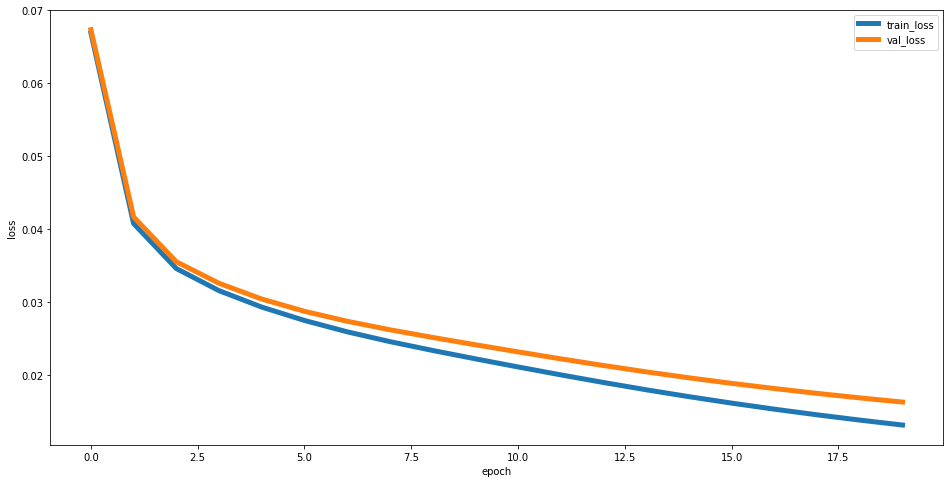

In [148]:
plot_learning_curve(model_tanh.train_loss, model_tanh.val_loss)

Learning curve of the Sigmoid function model

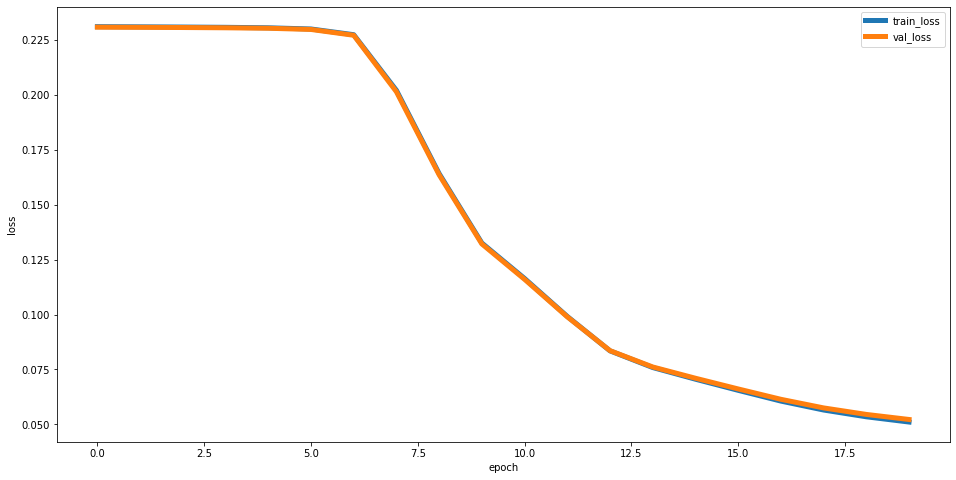

In [149]:
plot_learning_curve(model_sigmoid.train_loss, model_sigmoid.val_loss)

The training loss and validation loss is nearly the same, because the model does not having a relatively high accuracy and seems promising to perform better with more epoch.

In [152]:
model_sigmoid2 = ScratchSimpleNeuralNetrowkClassifier(epoch=40, activation='sigmoid', verbose=True)
model_sigmoid2.fit(X_train, y_train_one_hot, X_val, y_val_one_hot)

epoch: 0, loss: 0.23102131414478314
epoch: 1, loss: 0.23094543516218763
epoch: 2, loss: 0.2308549592135755
epoch: 3, loss: 0.2307303025291711
epoch: 4, loss: 0.23051443746295391
epoch: 5, loss: 0.22997220749145136
epoch: 6, loss: 0.22737421334118862
epoch: 7, loss: 0.20203816866459662
epoch: 8, loss: 0.1641331718753498
epoch: 9, loss: 0.1325288159601931
epoch: 10, loss: 0.11639371541597185
epoch: 11, loss: 0.09912638982474532
epoch: 12, loss: 0.08346568800120904
epoch: 13, loss: 0.0758672727952798
epoch: 14, loss: 0.07055915993814846
epoch: 15, loss: 0.06548762981196286
epoch: 16, loss: 0.06059397572465058
epoch: 17, loss: 0.056526700495863405
epoch: 18, loss: 0.05344481109048684
epoch: 19, loss: 0.05105593809266332
epoch: 20, loss: 0.04906926912620815
epoch: 21, loss: 0.04732578260584319
epoch: 22, loss: 0.04578385192695958
epoch: 23, loss: 0.04445268427229625
epoch: 24, loss: 0.043322249616973396
epoch: 25, loss: 0.04235509008990001
epoch: 26, loss: 0.0415069063054229
epoch: 27, loss

In [154]:
y_pred_sigmoid2 = model_sigmoid2.predict(X_val)
accuracy_score(y_pred_sigmoid2, y_val)

0.9016666666666666

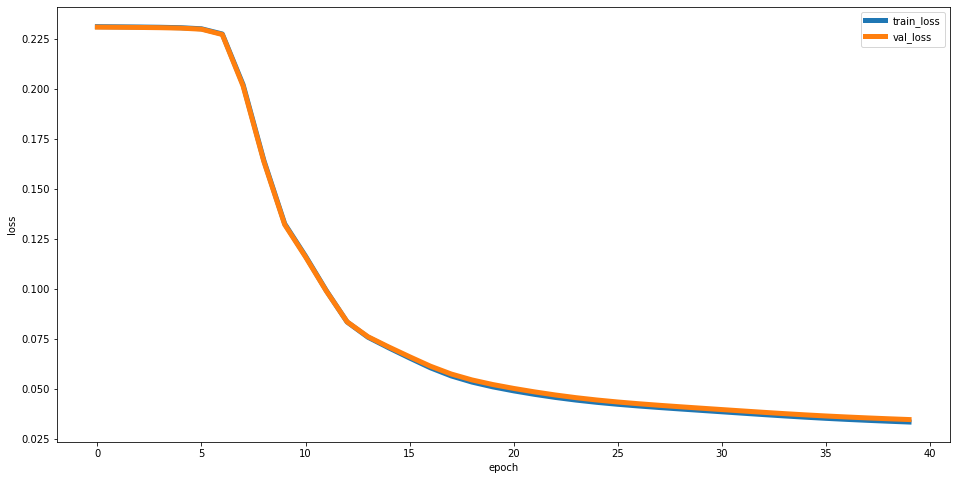

In [155]:
plot_learning_curve(model_sigmoid2.train_loss, model_sigmoid2.val_loss)

It seems like the Sigmoid function model learns very slow, but the performing can be really promising with more training.

##**Problem 8**
##(Advance assignment) Confirmation of misclassification

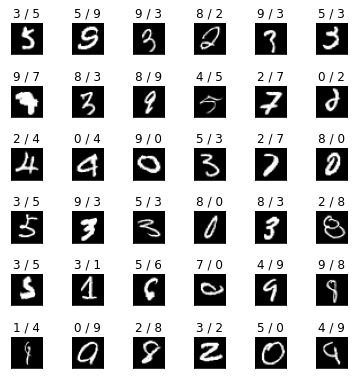

In [151]:
"""
Display word classification results side by side. The display above the image is "estimated result / correct answer".
Parameters:
----------
y_pred : Estimated ndarray (n_samples,)
y_val : Correct label of verification data (n_samples,)
X_val : Verification data features (n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt
num = 36 # How many to display

true_false = y_pred_tanh==y_val
false_list = np.where(true_false==False)[0].astype(np.int)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')